**Created on 11/01/2022**

**Group 2**

**Authors: Clarisse PONT**

**License: this code is released under the CeCILL 2.1 license. See https://www.cecill.info/licenses/Licence_CeCILL_V2.1-en.txt**

## Import libraries

In [23]:
import numpy as np
import urllib.parse
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
import math
import seaborn as sns 
from google.colab import drive
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance

In [8]:
sns.set_style('darkgrid')

## Import data

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/M2/PIP 2023/Données/Data_development/train_v5.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/M2/PIP 2023/Données/Data_development/test_v5.csv')
validation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/M2/PIP 2023/Données/Data_development/validation_v5.csv')

In [11]:
Y_train = train[['loc_initiator_x', 'loc_initiator_y']]
X_train = train.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_test = test[['loc_initiator_x', 'loc_initiator_y']]
X_test = test.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

Y_val = validation[['loc_initiator_x', 'loc_initiator_y']]
X_val = validation.drop(["loc_initiator_x",'loc_initiator_y'], axis=1, inplace=False)

## Cross Validation

In [16]:
parameters = {'n_components':[3,6,9,12,20,30],
              'scale':[0,1,100,150,200],
              'max_iter' : [0,20,40,60,80,100,120,140,160,180,200,220,240,260,280,300,320,340,360,380,400,420,440,460,480,500]}
reg = PLSRegression()
clf = GridSearchCV(reg, parameters)
clf.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=14 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=14 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=14 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:230: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_component

GridSearchCV(estimator=PLSRegression(),
             param_grid={'max_iter': [0, 20, 40, 60, 80, 100, 120, 140, 160,
                                      180, 200, 220, 240, 260, 280, 300, 320,
                                      340, 360, 380, 400, 420, 440, 460, 480,
                                      500],
                         'n_components': [3, 6, 9, 12, 20, 30],
                         'scale': [0, 1, 100, 150, 200]})

In [17]:
params_opti = clf.cv_results_['params'][clf.best_index_]
params_opti

{'max_iter': 20, 'n_components': 9, 'scale': 1}

## Predict

In [18]:
reg = PLSRegression(max_iter = params_opti['max_iter'], n_components = params_opti['n_components'], scale = params_opti['scale'])
reg = reg.fit(X_train, Y_train)
pred_test = reg.predict(X_test)
pred_val = reg.predict(X_val)

## Score

In [19]:
def score_distanceM(Xobserve:float, Yobserve:float, Xprevu:float, Yprevu:float) -> float:
    X=(Xobserve-Xprevu)**2
    Y=(Yobserve-Yprevu)**2
    return np.mean(np.sqrt(X+Y))

In [20]:
print("mae test : ", mean_absolute_error(Y_test, pred_test))
print("rmse test : ", np.sqrt(mean_squared_error(Y_test,pred_test)))
print("\n")
print("mae validation : ", mean_absolute_error(Y_val, pred_val))
print("rmse validation : ", np.sqrt(mean_squared_error(Y_val,pred_val)))

mae test :  1.9871025387414023
rmse test :  2.4601124388891846


mae validation :  1.0572367127929536
rmse validation :  1.3266112541946093


In [21]:
print("score distance test : ",
      score_distanceM(Xobserve = Y_test['loc_initiator_x'],
                      Yobserve = Y_test['loc_initiator_y'],
                      Xprevu = pred_test[:,0],
                      Yprevu = pred_test[:,1]))

score distance test :  2.923149914475997


In [22]:
print("score distance validation : ",
      score_distanceM(Xobserve = Y_val['loc_initiator_x'],
                      Yobserve = Y_val['loc_initiator_y'],
                      Xprevu = pred_val[:,0],
                      Yprevu = pred_val[:,1]))

score distance validation :  1.5552272207534956


## Feature important

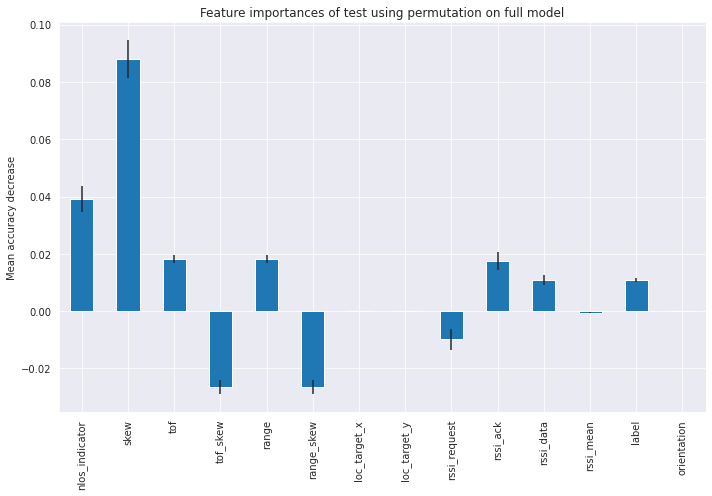

In [24]:
result = permutation_importance(reg, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=list(X_train.columns))

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances of test using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

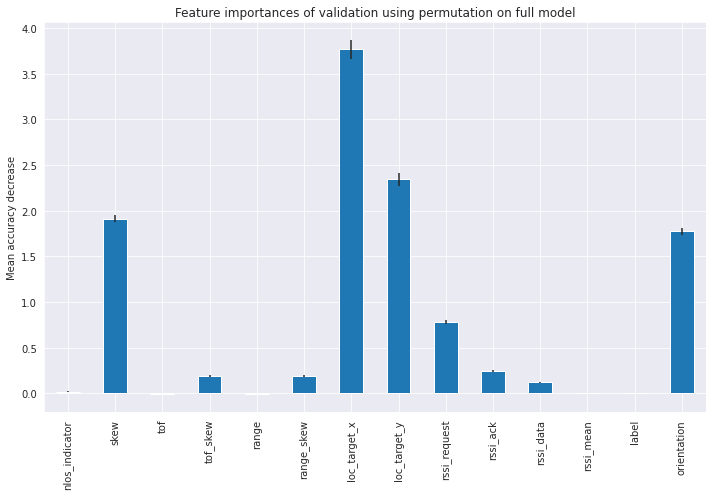

In [25]:
result = permutation_importance(reg, X_val, Y_val, n_repeats=10, random_state=42, n_jobs=2)
forest_importances = pd.Series(result.importances_mean, index=list(X_train.columns))

fig, ax = plt.subplots(figsize=(10, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances of validation using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()